In [30]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Approach 1

In [3]:
file = 'gender_classification_v1.h5'
with h5py.File(file, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    print(data)

Keys: <KeysViewHDF5 ['model_weights', 'optimizer_weights']>
['conv2d', 'conv2d_1', 'conv2d_2', 'dense', 'dense_1', 'dropout', 'flatten', 'max_pooling2d', 'max_pooling2d_1', 'max_pooling2d_2', 'rescaling_1', 'sequential']


In [4]:
def print_structure(name, obj):
    print(name, type(obj))

with h5py.File(file, 'r') as f:
    f.visititems(print_structure)


model_weights <class 'h5py._hl.group.Group'>
model_weights/conv2d <class 'h5py._hl.group.Group'>
model_weights/conv2d/conv2d <class 'h5py._hl.group.Group'>
model_weights/conv2d/conv2d/bias:0 <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d/conv2d/kernel:0 <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_1 <class 'h5py._hl.group.Group'>
model_weights/conv2d_1/conv2d_1 <class 'h5py._hl.group.Group'>
model_weights/conv2d_1/conv2d_1/bias:0 <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_1/conv2d_1/kernel:0 <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_2 <class 'h5py._hl.group.Group'>
model_weights/conv2d_2/conv2d_2 <class 'h5py._hl.group.Group'>
model_weights/conv2d_2/conv2d_2/bias:0 <class 'h5py._hl.dataset.Dataset'>
model_weights/conv2d_2/conv2d_2/kernel:0 <class 'h5py._hl.dataset.Dataset'>
model_weights/dense <class 'h5py._hl.group.Group'>
model_weights/dense/dense <class 'h5py._hl.group.Group'>
model_weights/dense/dense/bias:0 <class 'h5py._hl.dataset.Da

In [16]:
# Open the HDF5 file
file_path = 'gender_classification_v1.h5'
with h5py.File(file_path, 'r') as file:
    # Extract weights from a convolutional layer
    conv1_weights = file['model_weights/conv2d/conv2d/kernel:0'][:]
    conv1_bias = file['model_weights/conv2d/conv2d/bias:0'][:]

    # Extract weights from a dense layer
    # dense1_weights = file['model_weights/dense/dense/kernel:0'][:]
    # dense1_bias = file['model_custom_weights/dense/dense/bias:0'][:]
    dense1_weights = file['model_weights/dense_1/dense_1/kernel:0'][:]
    dense1_bias = file['model_weights/dense_1/dense_1/bias:0'][:]

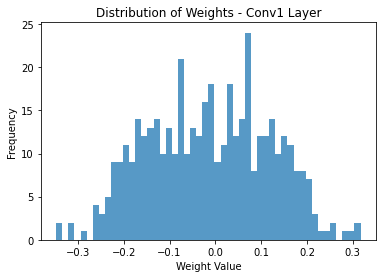

In [17]:
# Showing weights distribution of the first convolutional layer
plt.hist(conv1_weights.flatten(), bins=50, alpha=0.75)
plt.title('Distribution of Weights - Conv1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()

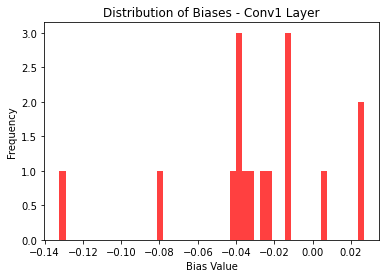

In [18]:
# Showing biases for the same layer
plt.hist(conv1_bias.flatten(), bins=50, alpha=0.75, color='red')
plt.title('Distribution of Biases - Conv1 Layer')
plt.xlabel('Bias Value')
plt.ylabel('Frequency')
plt.show()

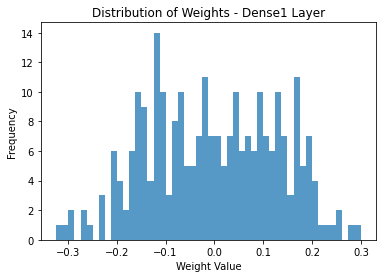

In [19]:
# Plotting for the dense layer
plt.hist(dense1_weights.flatten(), bins=50, alpha=0.75)
plt.title('Distribution of Weights - Dense1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.show()

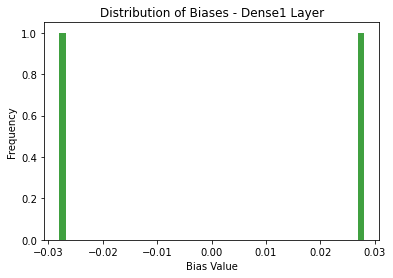

In [20]:
plt.hist(dense1_bias.flatten(), bins=50, alpha=0.75, color='green')
plt.title('Distribution of Biases - Dense1 Layer')
plt.xlabel('Bias Value')
plt.ylabel('Frequency')
plt.show()

# Approach 2

In [28]:
layer_types = {}
with h5py.File(file_path, 'r') as file:
    # Collect names and sizes (number of parameters) of each layer by type
    for layer_key in file['model_weights'].keys():
        # Identify layer type from the layer name
        layer_type = layer_key.split('_')[0]  # e.g., 'conv', 'dense', 'flatten', 'dropout'
        # Checking if there are kernels (trainable parameters) to count
        if list(file[f'model_weights/{layer_key}'].keys()):
            weights_key = list(file[f'model_weights/{layer_key}'].keys())[0]
            if 'kernel:0' in file[f'model_weights/{layer_key}/{weights_key}']:
                weights = file[f'model_weights/{layer_key}/{weights_key}/kernel:0'][:]
                # Summing parameters by type
                if layer_type in layer_types:
                    layer_types[layer_type] += weights.size
                else:
                    layer_types[layer_type] = weights.size


### Plot 1

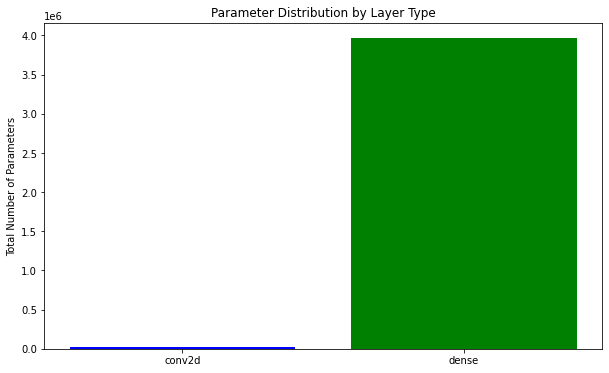

In [29]:

# Data for plotting
labels = list(layer_types.keys())
sizes = list(layer_types.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Total Number of Parameters')
plt.title('Parameter Distribution by Layer Type')
plt.show()


In [31]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(layer_types.items()), columns=['Layer Type', 'Number of Parameters'])

# Save the DataFrame to CSV
df.to_csv('model_layer_parameters.csv', index=False)

### Plot 2

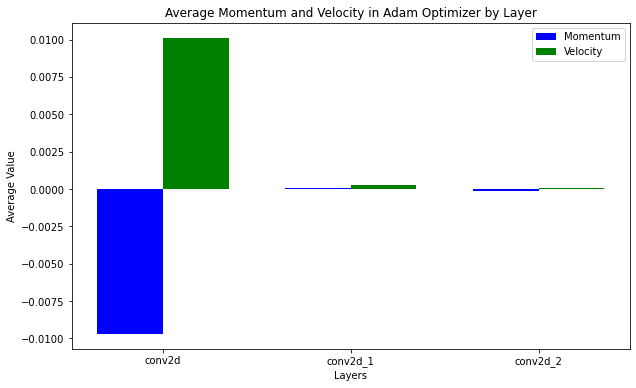

In [34]:
momentums = []
velocities = []
layer_labels = []

with h5py.File(file_path, 'r') as file:
    # Iterate over convolutional layers to collect optimizer data
    for layer in ['conv2d', 'conv2d_1', 'conv2d_2']:
        if 'Adam' in file['optimizer_weights']:
            # Momentum
            m_key = f'optimizer_weights/Adam/{layer}/kernel/m:0'
            if m_key in file:
                m_data = file[m_key][:]
                avg_momentum = np.mean(m_data)
                momentums.append(avg_momentum)
            
            # Velocity
            v_key = f'optimizer_weights/Adam/{layer}/kernel/v:0'
            if v_key in file:
                v_data = file[v_key][:]
                avg_velocity = np.mean(v_data)
                velocities.append(avg_velocity)
            
            layer_labels.append(layer)

# Plotting
plt.figure(figsize=(10, 6))
width = 0.35  # the width of the bars
indices = np.arange(len(momentums))

plt.bar(indices - width/2, momentums, width, label='Momentum', color='blue')
plt.bar(indices + width/2, velocities, width,  label='Velocity', color='green')

plt.xlabel('Layers')
plt.ylabel('Average Value')
plt.title('Average Momentum and Velocity in Adam Optimizer by Layer')
plt.xticks(indices, layer_labels)
plt.legend()

plt.show()


In [41]:
# Data containers
data = {
    'Layer': [],
    'Momentum': [],
    'Velocity': []
}

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Iterate over the layers for which you want to extract the data
    layers = ['conv2d', 'conv2d_1', 'conv2d_2']
    for layer in layers:
        # Construct the path to the momentum and velocity datasets
        m_key = f'optimizer_weights/Adam/{layer}/bias/m:0'
        v_key = f'optimizer_weights/Adam/{layer}/bias/v:0'
        
        # Check if the paths exist in the file
        if m_key in file and v_key in file:
            # Extract momentum and velocity data
            momentum = np.mean(file[m_key][:])
            velocity = np.mean(file[v_key][:])
            
            # Append the data to the respective lists
            data['Layer'].append(layer)
            data['Momentum'].append(momentum)
            data['Velocity'].append(velocity)

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('adam_optimizer.csv', index=False)


### Plot 3

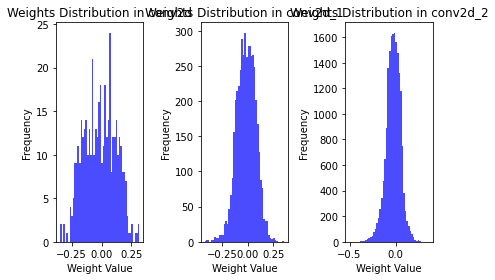

In [39]:
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # We'll plot histograms for the first three convolutional layers
    layers = ['conv2d', 'conv2d_1', 'conv2d_2']
    for i, layer in enumerate(layers, 1):
        # Access the kernel weights
        weights_key = f'model_weights/{layer}/{layer}/kernel:0'
        if weights_key in file:
            weights = file[weights_key][:]
            # Create a subplot for each layer's weights
            plt.subplot(1, 3, i)
            plt.hist(weights.flatten(), bins=50, color='blue', alpha=0.7)
            plt.title(f'Weights Distribution in {layer}')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')

# Display the plot
plt.subplots_adjust(left=0.05, right=0.95, wspace=0.35, hspace=0.35)
plt.tight_layout()
plt.show()

In [42]:
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Data dictionary to hold weight data
    data = {'Layer': [], 'Weights': []}
    
    # We'll extract weights for the first three convolutional layers
    layers = ['conv2d', 'conv2d_1', 'conv2d_2']
    for layer in layers:
        # Access the kernel weights
        weights_key = f'model_weights/{layer}/{layer}/kernel:0'
        if weights_key in file:
            weights = file[weights_key][:]
            # Flatten the weights and store them with corresponding layer name
            data['Layer'].extend([layer] * len(weights.flatten()))
            data['Weights'].extend(weights.flatten())

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('weight_distributions.csv', index=False)


### Plot 4

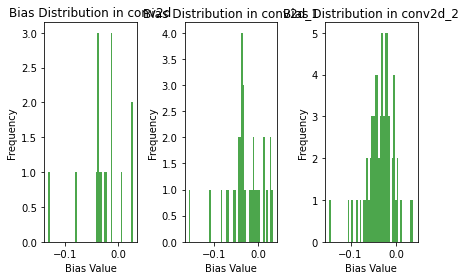

In [43]:
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Specify the convolutional layers to plot
    layers = ['conv2d', 'conv2d_1', 'conv2d_2']
    for i, layer in enumerate(layers, 1):
        # Access the bias values
        bias_key = f'model_weights/{layer}/{layer}/bias:0'
        if bias_key in file:
            biases = file[bias_key][:]
            # Create a subplot for each layer's bias distribution
            plt.subplot(1, 3, i)
            plt.hist(biases.flatten(), bins=50, color='green', alpha=0.7)
            plt.title(f'Bias Distribution in {layer}')
            plt.xlabel('Bias Value')
            plt.ylabel('Frequency')

# Adjust layout to ensure no overlap
plt.tight_layout()
plt.show()


### Plot 5

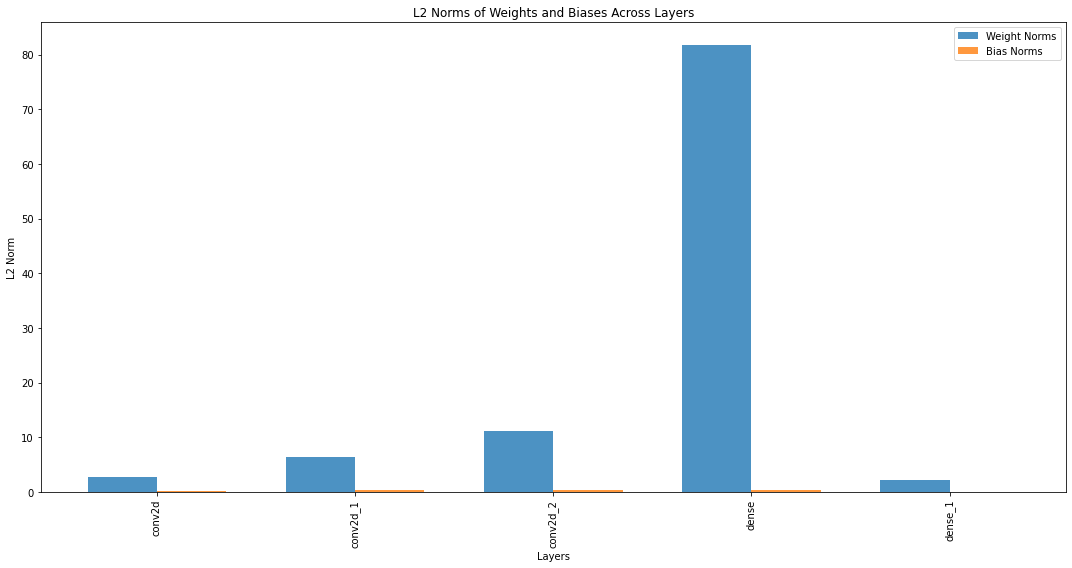

In [47]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Path to the HDF5 file
file_path = 'gender_classification_v1.h5'

# Initialize lists to store layer names and their norms
layer_names = []
weight_norms = []
bias_norms = []

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Loop through layers to calculate norms
    for layer_key in file['model_weights'].keys():
        layer_group = file['model_weights'][layer_key]
        
        # Initialize norms
        weight_norm = None
        bias_norm = None
        
        # Check if the layer has weights
        for key in layer_group.keys():
            if 'kernel:0' in layer_group[key]:
                weights = layer_group[key]['kernel:0'][:]
                weight_norm = np.linalg.norm(weights)
            if 'bias:0' in layer_group[key]:
                biases = layer_group[key]['bias:0'][:]
                bias_norm = np.linalg.norm(biases)
        
        # Only append if norms were found
        if weight_norm is not None or bias_norm is not None:
            layer_names.append(layer_key)
            weight_norms.append(weight_norm if weight_norm is not None else 0)
            bias_norms.append(bias_norm if bias_norm is not None else 0)

# Plotting
plt.figure(figsize=(15, 8))
index = np.arange(len(layer_names))
bar_width = 0.35

plt.bar(index, weight_norms, bar_width, label='Weight Norms', alpha=0.8)
plt.bar(index + bar_width, bias_norms, bar_width, label='Bias Norms', alpha=0.8)

plt.xlabel('Layers')
plt.ylabel('L2 Norm')
plt.title('L2 Norms of Weights and Biases Across Layers')
plt.xticks(index + bar_width / 2, layer_names, rotation=90)
plt.legend()
plt.tight_layout()  # Adjust subplots to give room for labels

plt.show()


In [48]:
import h5py
import numpy as np
import pandas as pd

# Path to the HDF5 file
file_path = 'gender_classification_v1.h5'

# Initialize lists to store layer names and their norms
layer_names = []
weight_norms = []
bias_norms = []

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Loop through layers to calculate norms
    for layer_key in file['model_weights'].keys():
        layer_group = file['model_weights'][layer_key]
        
        # Initialize norms
        weight_norm = None
        bias_norm = None
        
        # Check if the layer has weights
        for key in layer_group.keys():
            if 'kernel:0' in layer_group[key]:
                weights = layer_group[key]['kernel:0'][:]
                weight_norm = np.linalg.norm(weights)
            if 'bias:0' in layer_group[key]:
                biases = layer_group[key]['bias:0'][:]
                bias_norm = np.linalg.norm(biases)
        
        # Only append if norms were found
        if weight_norm is not None or bias_norm is not None:
            layer_names.append(layer_key)
            weight_norms.append(weight_norm if weight_norm is not None else 0)
            bias_norms.append(bias_norm if bias_norm is not None else 0)

# Prepare the data for CSV
data = {
    'Layer': layer_names,
    'Weight Norm': weight_norms,
    'Bias Norm': bias_norms
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Specify the path for the CSV file
csv_file_path = 'L2_norms.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

